In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pymeos import *

pymeos_initialize()

/tmp/ipykernel_9680/3150268805.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
ais = pd.read_csv('./data/aisinput.csv')

ais.head()

,t,mmsi,latitude,longitude,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


In [7]:
filtered_ais = ais.copy()
# filtered_ais = ais[ais["MMSI"] == 2182807]

In [8]:
filtered_ais['point'] = filtered_ais.apply(lambda row: TGeogPointInst(point=(row['latitude'], row['longitude']), timestamp=row['t']),
                         axis=1)
filtered_ais['sog'] = ais.apply(lambda row: TFloatInst(value=row['sog'], timestamp=row['t']), axis=1)
filtered_ais.head()

,t,mmsi,latitude,longitude,sog,point
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0@2021-01-08 00:00:00+01,POINT(57.059 12.272388)@2021-01-08 00:00:00+01
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0@2021-01-08 00:00:01+01,POINT(55.94244 11.866278)@2021-01-08 00:00:01+01
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0@2021-01-08 00:00:01+01,POINT(57.059 12.272388)@2021-01-08 00:00:01+01
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0@2021-01-08 00:00:03+01,POINT(55.94244 11.866278)@2021-01-08 00:00:03+01
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0@2021-01-08 00:00:04+01,POINT(57.059 12.272388)@2021-01-08 00:00:04+01


In [9]:
trajectories = filtered_ais.groupby('mmsi').aggregate(
    {
        'point': TGeogPointSeq.from_instants,
        'sog': TFloatSeq.from_instants
    }
).rename({'point': 'trajectory'}, axis=1)
trajectories['distance'] = trajectories['trajectory'].apply(lambda t: t.length())
trajectories.head()

,trajectory,sog,distance
mmsi,,,
219001559,[POINT(57.592245 9.975512)@2021-01-08 00:00:05...,"[0.1@2021-01-08 00:00:05+01, 0.1@2021-01-08 00...",17765.588739
219027804,[POINT(55.94244 11.866278)@2021-01-08 00:00:01...,"[0@2021-01-08 00:00:01+01, 0@2021-01-08 00:34:...",94963.575026
257136000,[POINT(56.911257 7.122958)@2021-01-08 00:02:57...,"[14@2021-01-08 00:02:57+01, 13.9@2021-01-08 00...",940404.131239
265513270,[POINT(57.059 12.272388)@2021-01-08 00:00:00+0...,"[0@2021-01-08 00:00:00+01, 0@2021-01-08 00:00:...",1629.539165
566948000,[POINT(55.574352 4.617153)@2021-01-08 00:00:04...,"[0.5@2021-01-08 00:00:04+01, 0.5@2021-01-08 00...",28215.190430


In [10]:
pd.concat([filtered_ais.groupby('mmsi')['t'].count().rename('original #points'),
           trajectories['trajectory'].apply(lambda t: t.num_instants()).rename('PyMEOS #points')],
          axis=1)

,original #points,PyMEOS #points
mmsi,,
219001559,48323,36494
219027804,38326,17161
257136000,21770,21120
265513270,21799,7954
566948000,26619,24175


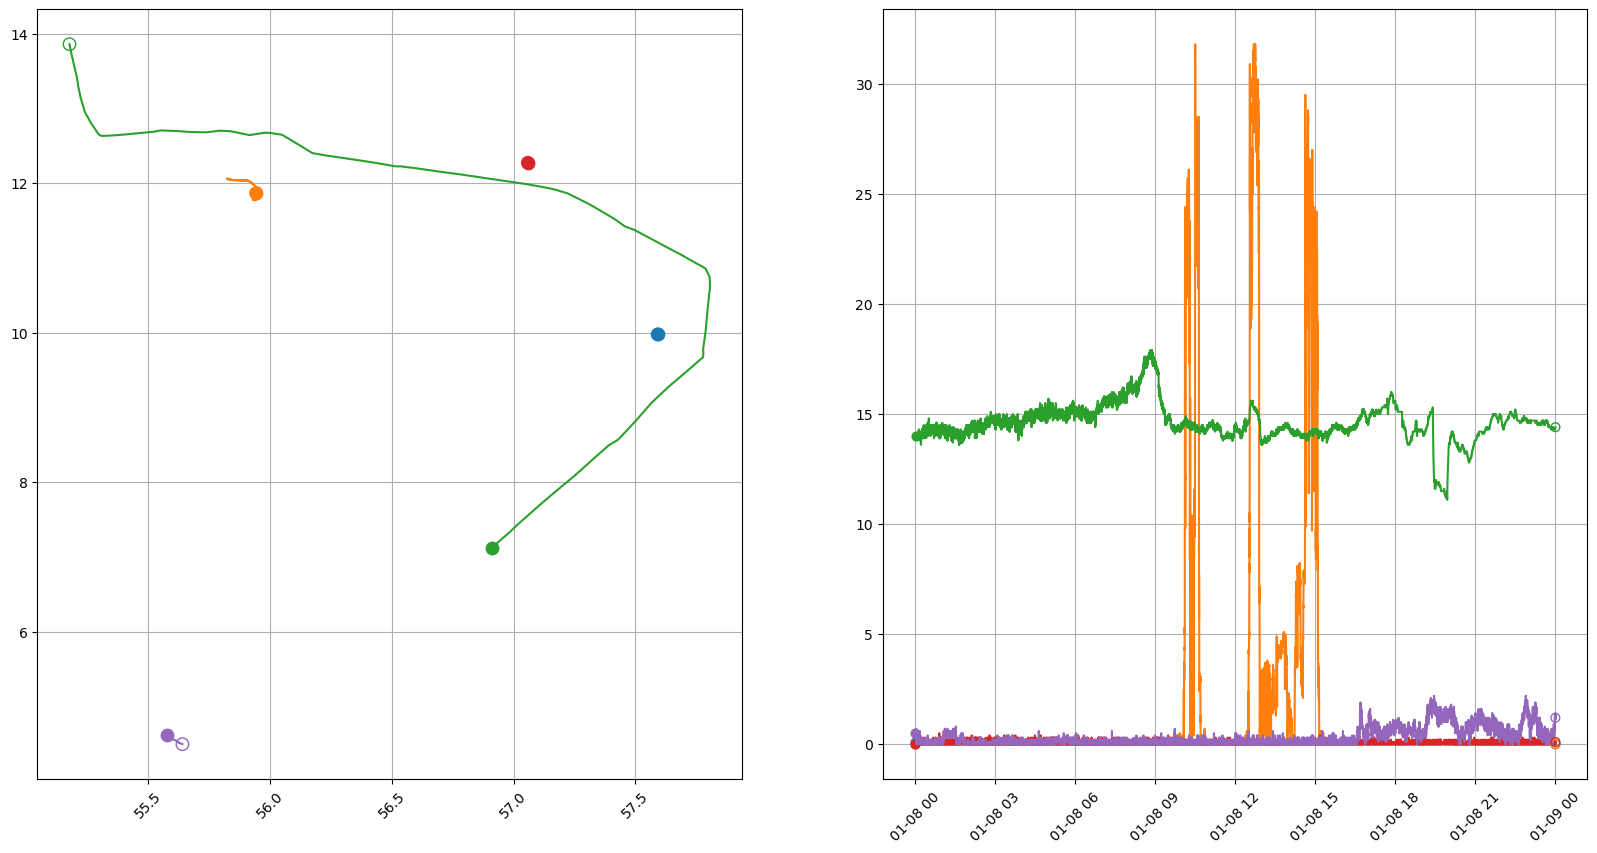

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for _, ship in trajectories.iterrows():
    ship['trajectory'].plot(axes=axes[0])
    ship['sog'].plot(axes=axes[1])
plt.show()

In [12]:
pymeos_finalize()